# Data Augmentation

Data Augmentation is a set of techniques used to generate _altered_ images from a set of _original_ images.
Examples of these techniques are: changing colors, flipping, cropping, or tweeking the images in some way, while keeping the class labels the same.
The goal of applying these techniques is to increase the _generalization_ of the model.
It helps with over-fitting, makes the model more invariant to new unseen data, and learns more important/robust features. 

In this numerical example we will mostly talk about two types of data augmentation.
 1. **Dataset Expansion**
 2. **Batch Augmentation**


## 1. Dataset Expansion

It is commonly known that neural networks require quite a bit of training data ino order to refine its predictions.
But it is not always the case that one has a lot of data at hand.
In these cases dataset expansion using data augmentation could be deemed advantagous. 

Let's present the flow of this method.
Assume that you have a dateset of 100 distinct images.
The task is then to expand this dataset to a bigger one, let's say approximately 1000 images.
To do this, one takes the images and apply one or two augmentation techniques to all of them, and append the mutated images to the original dataset.
This process is then repeated until one has the desired amount of data.
Keep in mind that the labels are kept during this augmentation. 

![Data expansion](https://i.imgur.com/3NTjaqb.png)

There is one central fact regarding _dataset expansion_ that needs to be mentioned, namely that the data augmentation is done **prior** to training.
Once the augmentation has been applied, the training epochs train on the expanded dataset, and there is no randomization involved in exactly _which_ augmentations are used during training; the augmented training dataset is identical for _every_ training epoch.
Why is this important?
Since there is no randomization in the augmentation, the network may still be able to train until it is overfitted for the expanded dataset.
It may be true that the network is more generalized, since it has been trained to be invariant under rotation, color shifting, and so on, but it might have learned to be invariant solely for the trainig data, and it may still have troubles when encountering _truly_ new data.
Batch augmentation aims at rectifying this issue, which we will explain in the upcoming section.

## 2. Batch Augmentation

The method of batch augmentation is mostly used for the case of improving the generalization of the model.
The pipeline for this approach is to split the data into $n$ batches and feed one batch at a the time through a data augmentation function.
This data transformation function transforms the data at **random**, and passes the output into the ensuing convolutional neural network.
The random transformation is applied anew during each individual epoch, resulting in training data that is (close to being) unique across all epochs.
A visual representation is given below.

![Batch augmentation](https://i.imgur.com/XoCSPe4.png)

The conceptual idea behind batch augmentation is that we have introduced an artifical variation into the training set, which is intended to simulate real world variation.
Since every training step uses a gradient calculated on a semi-uniquely, randomized variation of the original image (hopefully still preserving enough information in order to classify the image), the network is only able to learn "true" robust features, thus preventing overfitting and strengthening the invariant properties of the CNN.
You will often see better performance on validation and test sets after having applied batch augmentation, a good indication of increased generalization of the model.

## Augmentation Techniques

We will now present different augmentation techniques, and discuss the potential validity of each augmentation in turn.
The magnitude of each transformation has been increased in order to clearly demonstrate the effect of each given transformation.
We are using a dataset of five images of five different classes, and are going to use the pytorch `datasets.ImageFolder` API in order to apply different augmentation techniques in each subsection.

We start by importing the necessary packages:

In [4]:
import PIL
from IPython.display import Image
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
print(torch.__version__)
plt.ion()   # interactive mode

1.3.1


We now implement a plotting function that will run six "dummy epochs" and show the result of each augmentation function.
The datastream is not fed into a real CNN after the augmentation, we will solely focus on how the data is actually augmented.

In [7]:
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

# plot function of 6 epochs of augmentation
def show_dataset(dataset, n=6):
    img = np.vstack([
        np.hstack([(dataset[i][0]) for _ in range(n)])
        for i
        in range(len(dataset))
    ])
    plt.imshow(img)
    plt.axis('off')

### Color

Color transformations can be a powerful tool if used correctly.
It can act as a simulated change in environment, like the change in lighting during the day, or different kinds of artificial lighting. 

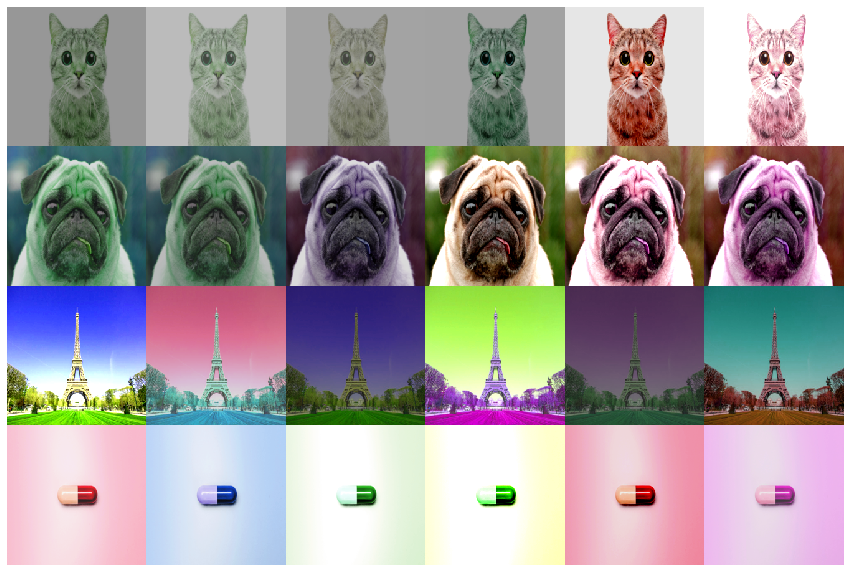

In [9]:
color = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(
        hue=0.4,
        saturation=0.4, 
        brightness=0.4,
        contrast=0.4,
    ),
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=color,
)
show_dataset(dataset)

The magnitude of this transformation is turned up, which makes the images really different from the original ones.
It may still be considered valid augmentations, mainly depending on context.
Color transformations of the Eiffel tower, for instance, may result in a network which is more able to classify the Eiffel tower in stylized artistic renditions of the tower.
If you intend to train a network that should solely work with real life photography, it may be necessary to tweak the color augmentation such that the augmentation reflects the natural variation caused by different lighting conditions, times of day, camera equipment, focal lengths, and so on.
Using the validation set in order to conduct numerical experiments informing this decision may often be necessary.

The same thing can be said of the pill.
Classifying if a given image contains a pill or not, may perform better under color augmentation.
But if the network is supposed to distinguish between _different types_ of pills, which are often color coded, the augmentation will probably prove to cause a severely negative impact on the performance of the network.

With other words, too much augmentation may reduce the correctness of the network, while too little may result in little gain in generalization.
This is highly dependent on the given problem which you aim to solve with the neural network, and you must select the types and magnitude of the augmentations accordingly.

### Flipping

Flipping images is also a common augmentation technique.
The validity of flipping is dependent on the _perspective_ of the image.
With a bird's-eye view, both horizontal and vertical flipping results in a valid image.
On the other hand, with a normal "photographer's perspective", only horizontal flipping will make sense, and only as long as the classification still makes sense with the mirror image of the original object.
Buildings, animals, and so on, are still preserved after generating the mirror image.
Finally, text can not be horizontally flipped, nor vertically, since characters in a up-down or mirror orientation loose their original interpretation.

We will now apply horizontal flipping at random for our original dataset.

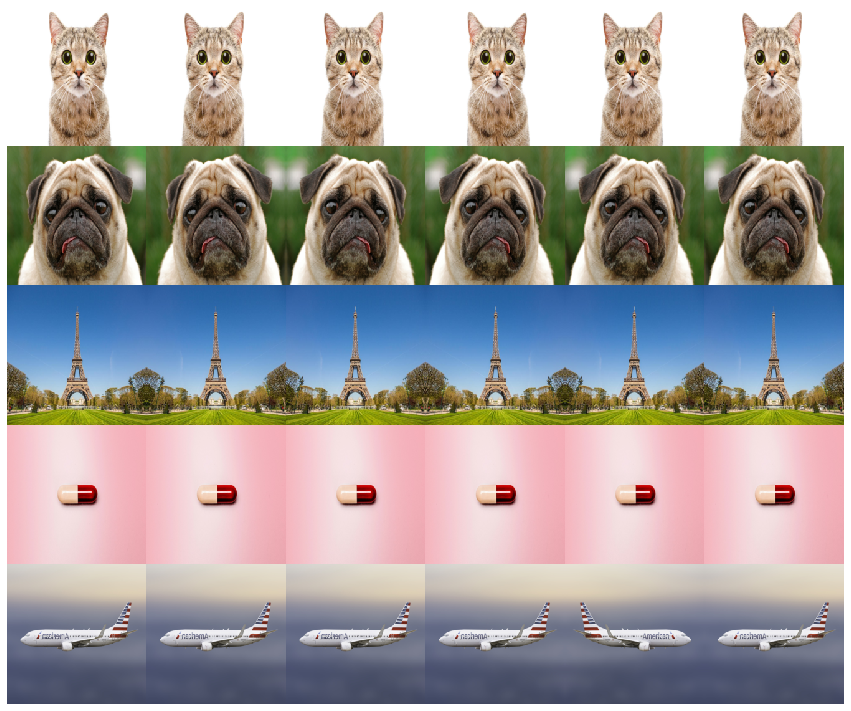

In [30]:
flipping_horizontal = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomHorizontalFlip()
])
dataset = datasets.ImageFolder('../numerical_examples/data/examples', 
                               transform=flipping_horizontal)
show_dataset(dataset)

We will now demonstrate how vertical flipping may be suboptimal for certain images.

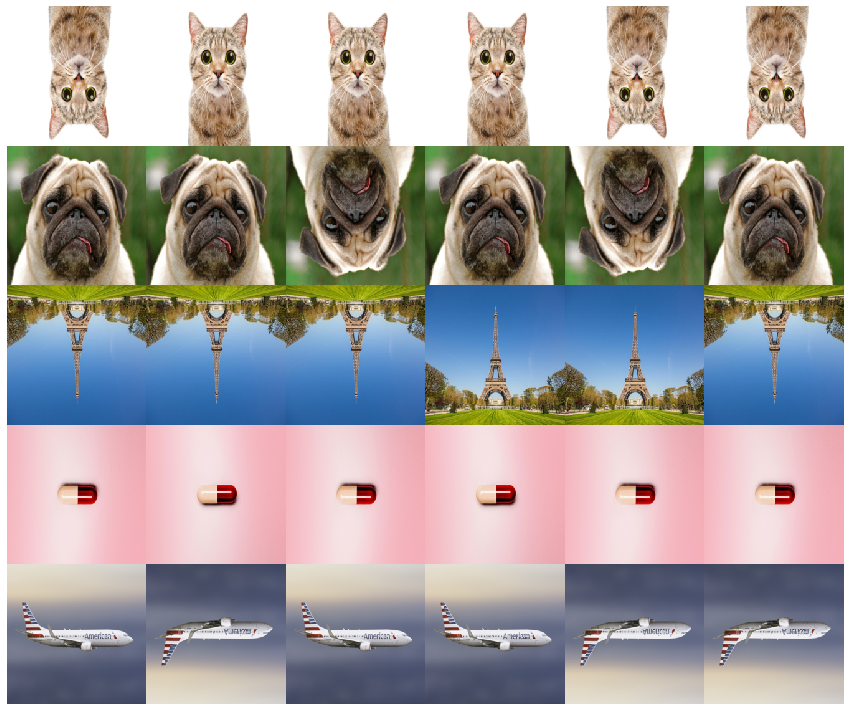

In [29]:
flipping_vertical = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomVerticalFlip()
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=flipping_vertical,
)
show_dataset(dataset)

It is only the pill that preserves its original interpretation after having applied a vertical flip, and this is mainly due to the bird's-eye perspective.
Combining the two flipping transformations might also in some cases work well, but the same thing can be said for each individual image here. 

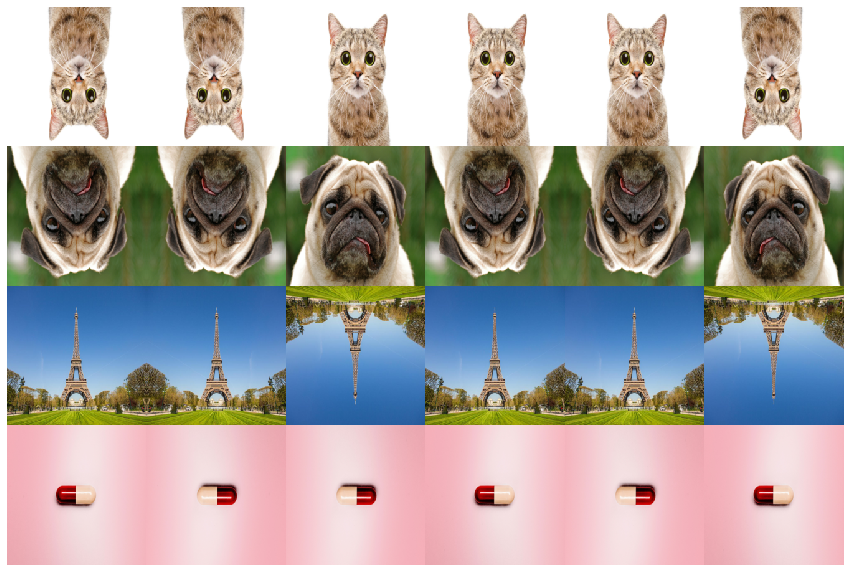

In [10]:
flipping = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomHorizontalFlip()
])
dataset = datasets.ImageFolder('../numerical_examples/data/examples', 
                               transform=flipping)
show_dataset(dataset)

### Rotation

A combination of horizontal and/or/nor vertical flipping can be thought of as a rotation, $\phi$, with $\phi$ restricted to the discrete domain $\{0, \pi/2, \pi, 3\pi/2\}$.
The benifit of flipping is that it is computationally cheap, as the array strides can be changed accordingly, and that there is no "loss" of pixels.
But there is no need to restrict rotation to this discrete domain, rotations in the entire $[0, 2\pi]$ domain can be used.
The benifit is that for some images where flipping can be considered invalid, small rotations may still be applicable.
There are still some disadvanteges, though:

* A rotation results in a new pixel grid, where values need to be filled in according to the original data. Bilinear interpolation is common, but it is more computationally intensive, and may in certain cases introduce artifacts into the image. LiDAR data is one such example.
* A rotation results in regions adjacent to the corners having no data at all, and other parts along the picture edges of the image may be entirely cropped away. These regions must be ignored by the network, which results in additional training complexity, or be filled in by extrapolated pixel data, which may be faulty in nature.

In practice, we will not use the entire $[0, 2\pi]$ domain for rotation, but rather restrict rotation to an angle domain of $(-\epsilon, \epsilon)$, with $\epsilon < \pi$.
The value used for $\epsilon$ depends on the context, the airplaine may be restricted to $(-\pi/4, \pi/4)$ to simulate airplanes during landing and lift-off for instance, while the pill remains valid for all rotations in the domain $(-\pi, \pi)$.

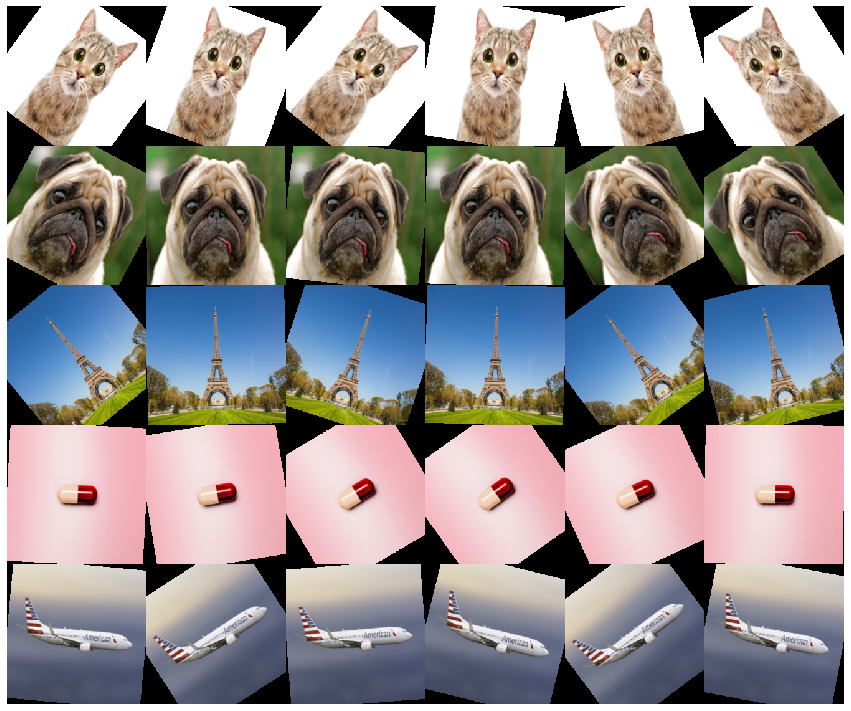

In [32]:
rotation = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomRotation(40, resample=PIL.Image.BILINEAR),
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=rotation,
)
show_dataset(dataset)

We can now observe the black areas where there is no data after rotation.
This can be removed by cropping the images after rotation, but this may result in data loss which makes classification infeasible if the object of interest is situated along the edges of the given image.

### Perspective

A change of prespective is also a powerfull tool if applied correctly.
Again, this yields in a black padding at the edges of the images, which one might want to account for.
We will now apply some quite extreme perspective changes in order to demonstrate this type of augmentation.

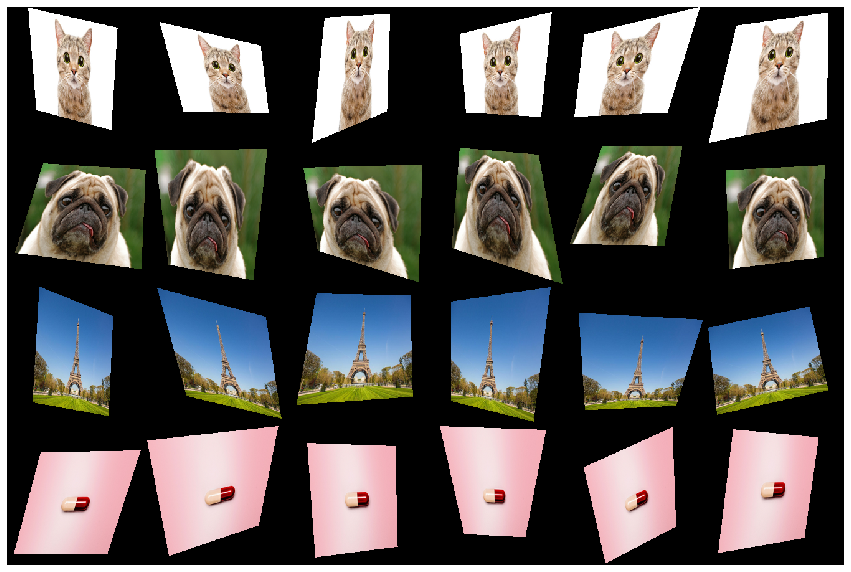

In [11]:
perspective = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1, interpolation=3)
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=perspective,
)
show_dataset(dataset)

### Crop and resize

The type of information lost due to cropping is highly dependent on the location of the object to be classified in the image.
Centered objects is not uncommon, and cropping may be an highly effective augmentation technique in such cases, since mainly random background "noise" is lost due to the cropping.
When the object is not sufficiently centered, the object may become partially obscured after cropping the image, which _can_ make the network more able to classify partially obscured objects in other images.
In other cases, you may lose too much of the important features in the object, resulting in worse performance.

We will now apply this type of augmentation, using images of the same size, and bilinear interpolation:

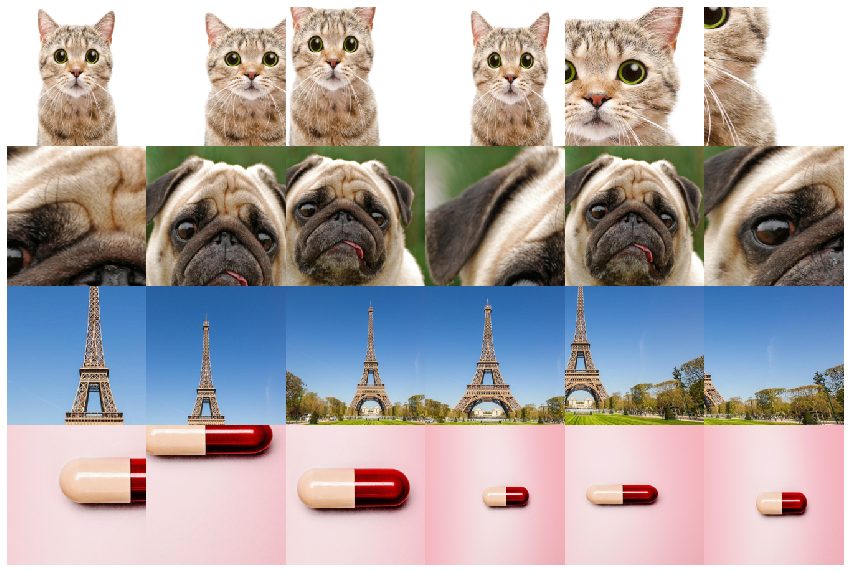

In [16]:
crop_resize = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(
        224, # image resize size
        scale=(0.08, 1.0), # range of size compared to the origin
        ratio=(0.75, 1.3333333333333333), # aspect ratio
    ),
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=crop_resize,
)
show_dataset(dataset)

### Everything together

Below we have given a example of combinations of the augmenations.
The magnitude of each is the same as above, which again makes some of the images very tweeked and most of these combination wouldn't yield good results.
It is therefore important to carefully tweak the hyperparameters of the augmenation.
Multiple papers have been writen on data augmentation and what techniques to use for this purpose.
In general one would apply some natural variation to the data, or in other words, a variation that is excected to arise from the real world distribution of images.

New advancements have been made in data augmenation by Google, called `AutoAugment`.
AutoAugment is a search based algorithm that finds the best augmentations and parameters to use on the datasets in order to achieve the greatest validation accuracy during trianing.
They define a search space and generate the augmentations using a Recurrent Neural Network(RNN).
They then feed the augmented batch into to the main network, which yields a resulting validation accuracy.
This validation accuracy is then fed into the controlled RNN to search for better augmentations (i.e. Reinforcement Learning).
This has also later been improved to Fast AutoAugment.

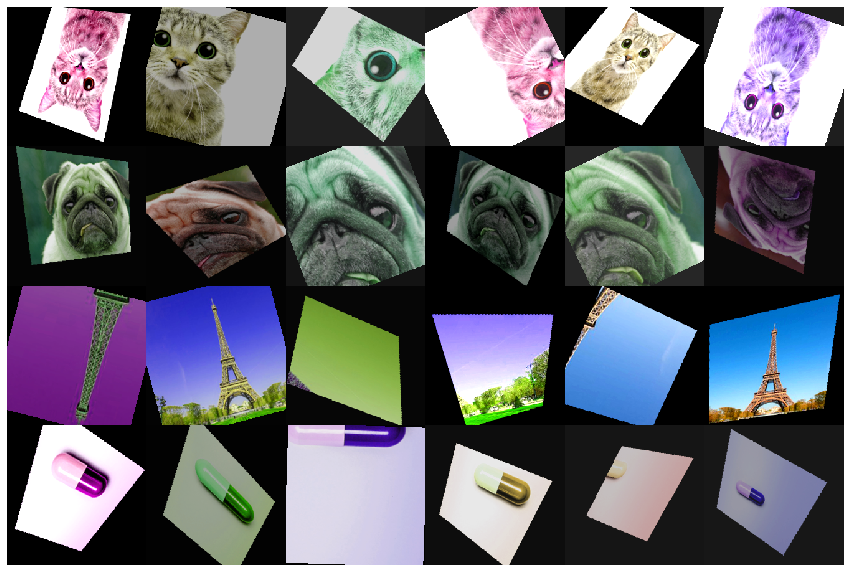

In [20]:
everything = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=3),
    torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=0.7, interpolation=3),
    torchvision.transforms.RandomRotation(40, resample=PIL.Image.BILINEAR),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(hue=.4, saturation=.4, brightness=.4,contrast=.4),
])
dataset = datasets.ImageFolder(
    '../numerical_examples/data/examples', 
    transform=everything,
)
show_dataset(dataset, n = 6)